# GCIMS (R package) and gc-ims-tools(Python Package) Comparison for pre-processing urines sampled with GC-IMS


## IMPORT LIBRARIES

In [1]:
import ims
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
from sklearn import decomposition
import multiprocessing
from joblib import Parallel, delayed

## LOAD DATASETS

First the peak table obtained with the GCIMS R package is imported along with the annotations

In [2]:
dataR=pd.read_csv("peak_table_R.csv",index_col=0)
#dataR.index=range(dataR.shape[0])
annotations=pd.read_csv("annotations.csv",index_col=0)
annotations["Sex_b"]=[int(b) for b in annotations["Sex"]=="Male"]

Then the raw data obtained with the GC-IMS is imported and pre-processed with the gc-ims-tools Python package

In [3]:
ds=ims.Dataset.read_mea("Urines")
ds.binning(2).cut_dt(7, 17).cut_rt(0, 1300)
ds.interp_riprel()
ds.scaling()
ds.tophat()
X,y=ds.get_xy()
dataP=pd.DataFrame(X)
dataP.index=annotations.index

Dataset: Urines, 56 Spectra

## Get Predictions with optimized Latent Variables

Function to find the latent variables that produce the best AUC

In [5]:
def optim(Xtrain,annotations,j):
    predL=pd.DataFrame()
    for k in np.unique(annotations["ID"]):
        XtrainL=Xtrain.loc[annotations["ID"]!=k].values.tolist()
        XtestL=Xtrain.loc[annotations["ID"]==k].values.tolist()
        YtrainL=annotations[annotations["ID"]!=k]["Sex_b"].values.tolist()
        YtestL=annotations[annotations["ID"]==k]["Sex_b"].values.tolist()
        plsL=PLSRegression(n_components=j, scale=True)
        plsL.fit(XtrainL,YtrainL)
        L=pd.DataFrame(plsL.predict(XtestL))
        L["Label"]=YtestL
        predL=pd.concat([predL,L])
    auc=metrics.roc_auc_score(predL['Label'],predL[0])
    return auc

Cross Validation with optimal number of latent variables for data preprocesed with GCIMS R package (peak table)

In [6]:
predR=pd.DataFrame()
lvhR=[]
for i in np.unique(annotations["ID"]):
    Xtrain=dataR.loc[annotations["ID"]!=i]
    annotations_optim=annotations.loc[annotations["ID"]!=i]
    #Parallelization for optimizing latent variables
    AUCL = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(optim)(Xtrain,annotations_optim,j) for j in range(1,7))
    LV=AUCL.index(max(AUCL))+1
    lvhR.append(LV)
    Xtrain=dataR.loc[annotations["ID"]!=i].values.tolist()
    Xtest=dataR.loc[annotations["ID"]==i].values.tolist()
    Ytrain=annotations[annotations["ID"]!=i]["Sex_b"].values.tolist()
    Ytest=annotations[annotations["ID"]==i]["Sex_b"].values.tolist()
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    A=pd.DataFrame(pls.predict(Xtest))
    A["Label"]=Ytest
    predR=pd.concat([predR,A])   
AUCR=metrics.roc_auc_score(predR['Label'],predR[0])

Cross Validation with optimal number of latent variables for data preprocesed with gc-ims-tools for Python

In [9]:
#This may take a while since it's working with the full matrix
predP=pd.DataFrame()
lvhP=[]
for i in np.unique(annotations["ID"]):
    Xtrain=dataP.loc[annotations["ID"]!=i]
    annotations_optim=annotations.loc[annotations["ID"]!=i]
    #Parallelization for optimizing latent variables/ uncomment if your computer can handle it
    #AUCLP = Parallel(n_jobs=multiprocessing.cpu_count()-4)(delayed(optim)(Xtrain,annotations_optim,j) for j in range(1,7)) 
    #Comment next 3 lines to use paralelization
    AUCLP=[]
    for j in range(1,7):
        a=optim(Xtrain,annotations_optim,j)
        AUCLP.append(a)
    LV=AUCL.index(max(AUCL))+1
    lvhP.append(LV)
    Xtrain=dataP.loc[annotations["ID"]!=i].values.tolist()
    Xtest=dataP.loc[annotations["ID"]==i].values.tolist()
    Ytrain=annotations[annotations["ID"]!=i]["Sex_b"].values.tolist()
    Ytest=annotations[annotations["ID"]==i]["Sex_b"].values.tolist()
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    A=pd.DataFrame(pls.predict(Xtest))
    A["Label"]=Ytest
    predP=pd.concat([predP,A]) 
AUCP=metrics.roc_auc_score(predP['Label'],predP[0])

## ROC COMPARISON

Comparison of ROC curves obtained with both preprocessing tehcniques in the same dataset

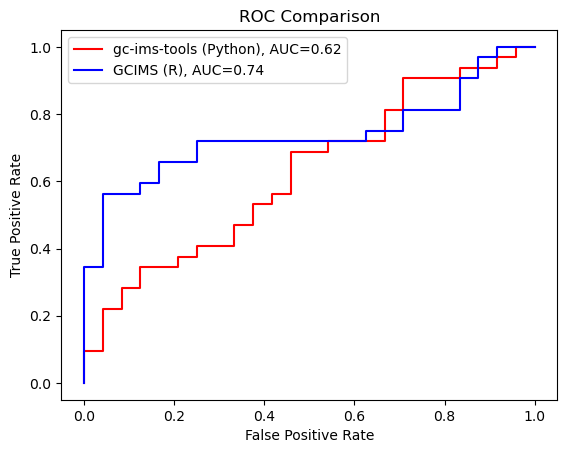

In [13]:
fprP, tprP, tP= metrics.roc_curve(predP["Label"],predP[0],drop_intermediate=False)
fprR, tprR, tR = metrics.roc_curve(predR["Label"],predR[0],drop_intermediate=False)
plt.plot(fprP,tprP,label="gc-ims-tools (Python), AUC="+str(round(AUCP, 2)),color='r')
plt.plot(fprR,tprR,label="GCIMS (R), AUC="+str(round(AUCR, 2)),color='b')
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison")
plt.legend()

## PERMUTATION TEST

In [17]:
# Function to generae each model with a random test label
def permutation(data,lvh,i):
    Xtrain=data.loc[annotations["ID"]!=i].values.tolist()
    Xtest=data.loc[annotations["ID"]==i].values.tolist()
    Ytrain=annotations[annotations["ID"]!=i]["Sex_b"].values.tolist()
    groups = np.unique(Ytrain)
    Ytest=rd.sample(groups.tolist(),1)*len(Xtest)
    LV=lvh[np.unique(annotations["ID"]).tolist().index(i)]
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    predPer=pd.DataFrame(pls.predict(Xtest))
    predPer["Label"]=Ytest
    return predPer

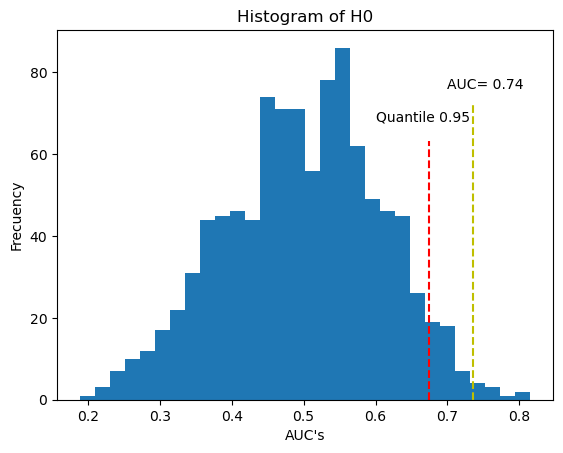

Confidence interval for the permutation test: [0.315 - 0.674]
AUC R: 0.7356770833333333
p-value: 0.01


In [18]:
permutR=[]
for j in range(1000):
    predPer = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(permutation)(dataR, lvhR, i) for i in np.unique(annotations["ID"]))
    pred=pd.DataFrame()
    for k in range(len(predPer)):
        pred=pd.concat([pred,predPer[k]])
    permutR.append(metrics.roc_auc_score(pred["Label"],pred[0]))
sorted_permut = np.array(permutR)
sorted_permut.sort()
confidence_lower = sorted_permut[int(0.05 * len(sorted_permut))]
confidence_upper = sorted_permut[int(0.95 * len(sorted_permut))]
plt.hist(permutR, bins=30)
plt.title('Histogram of H0')
plt.axvline(x=confidence_upper, ymax=0.7, color='r',linestyle="--")
plt.axvline(x=metrics.roc_auc_score(predR['Label'],predR[0]), ymax=0.8, color="y",linestyle="--")
plt.ylabel("Frecuency")
plt.xlabel("AUC's")
plt.text(0.6,68,"Quantile 0.95")
plt.text(0.7,76,f"AUC= {round(metrics.roc_auc_score(predR['Label'],predR[0]),2)}")
plt.show()
print("Confidence interval for the permutation test: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))    
print(f"AUC R: {metrics.roc_auc_score(predR['Label'],predR[0])}")
print(f"p-value: {len(np.where(np.array(permutR)>=metrics.roc_auc_score(predR['Label'],predR[0]))[0])/1000}")